In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})

Could not import QickSoc: No module named 'pynq'


C:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


C:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# State tomography analysis functions

Measurement occurs along 9 axes, each of which can give one of 4 values:

ZZ, ZX, ZY, XZ, XX, XY, YZ, YX, YY -> {00, 01, 10, 11}

In [3]:
meas_order = np.array(['ZZ', 'ZX', 'ZY', 'XZ', 'XX', 'XY', 'YZ', 'YX', 'YY'])
calib_order = np.array(['gg', 'ge', 'eg', 'ee'])

## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [4]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S12): # given 2 pauli matrix names, get the index at which that combo (or equivalent data) was measured
    assert S12[0] in 'IXYZ'
    assert S12[1] in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    if S12[0] == 'I': S12 = 'Z'+S12[1]
    if S12[1] == 'I': S12 = S12[0]+'Z'
    return np.argwhere(meas_order == S12)[0][0]
# print(order('II'))

In [5]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = [] # ordered in the same sequence as the n counts array (36 elements)
for S12 in meas_order:
    S1, S2 = S12
    psi1 = psi[S1]
    psi2 = psi[S2]
    psi_basis.append(qt.tensor(psi1[0], psi2[0])) # gg
    psi_basis.append(qt.tensor(psi1[0], psi2[1])) # ge
    psi_basis.append(qt.tensor(psi1[1], psi2[0])) # eg
    psi_basis.append(qt.tensor(psi1[1], psi2[1])) # ee

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [6]:
"""
n should be length 4 array containing single shot counts of measuring 00, 01, 10, 11 for measurement along axes i, j
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S1 and S2: I, X, Y, Z
"""
def Tij(n, S1, S2):
    assert 0 <= S1 <= 3 # S1, S2 represent pauli matrix indices
    assert 0 <= S2 <= 3
    signs = [1]*4
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1
    if S1 > 0: signs[2] *= -1; signs[3] *= -1
    if S2 > 0: signs[1] *= -1; signs[3] *= -1
    return np.sum(np.multiply(signs, n))


In [7]:
"""
Construct rho by adding together Tij for each of the 4^2 = 16 combinations of tensor product of 2 Pauli matrices
"""
def rho_from_counts(n):
    rho = 0*qt.tensor(qt.qeye(2), qt.qeye(2))
    for i in range(4): # loop over pauli matrices for qubit 1
        for j in range(4): # loop over pauli matrices for qubit 2
            o = order(i2s(i) + i2s(j)) # get the right 4 elements in the n matrix
            # print(i2s(i), i2s(j), Tij(n[4*o:4*(o+1)], i, j))
            rho += Tij(n[4*o:4*(o+1)], i, j) * qt.tensor(pauli(i), pauli(j))
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    return rho.full()

### Generate test data

In [8]:
def generate_counts(rho_id, n_tot, noise=1.0):
    n = []
    for psi in psi_basis:
        # measure in psi basis
        n.append(n_tot * (psi * psi.dag() * rho_id).tr())
    n = np.reshape(np.array(n), (len(psi_basis)//4, 4))

    # introduce gaussian noise
    for n_psi in n:
        n_meas = sum(n_psi)
        new_n3 = -1
        while new_n3 < 0:
            new_n012 = np.random.normal(loc=n_psi[:3], scale=noise*np.sqrt(n_psi[:3]))
            # preserve original total count per measurement
            new_n3 = n_meas - sum(new_n012)
        n_psi[:3] = np.round(new_n012)
        n_psi[3] = np.round(new_n3)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [9]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions
This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

I still don't understand why np linalg LDL* decomposition doesn't work, but I think it has something to do with the way I was trying to handle the permutation matrices, but I give up for now.

In [10]:
def det_ij(rho, i, j):
    M = np.delete(rho, i, axis=0)
    M = np.delete(M, j, axis=1)
    return np.linalg.det(M)

def det_ijkl(rho, i, j, k, l):
    M = np.delete(rho, [i,k], axis=0)
    M = np.delete(M, [j,l], axis=1)
    return np.linalg.det(M)
        
def t_from_rho(rho):
    t = []
    det = np.linalg.det(rho)
    det00 = det_ij(rho, 0, 0)
    det01 = det_ij(rho, 0, 1)
    det0011 = det_ijkl(rho, 0, 0, 1, 1)
    det0012 = det_ijkl(rho, 0, 0, 1, 2)
    det0112 = det_ijkl(rho, 0, 1, 1, 2)
    t = [np.sqrt(det/det00), np.sqrt(det00/det0011), np.sqrt(det0011/rho[3,3]), np.sqrt(rho[3,3])]
    t56 = det01/np.sqrt(det00*det0011)
    t.extend([np.real(t56), np.imag(t56)])
    t78 = det0012/np.sqrt(rho[3,3]*det0011)
    t.extend([np.real(t78), np.imag(t78)])
    t910 = rho[3,2]/np.sqrt(rho[3,3])
    t.extend([np.real(t910), np.imag(t910)])
    t1112 = det0112/np.sqrt(rho[3,3]*det0011)
    t.extend([np.real(t1112), np.imag(t1112)])
    t1314 = rho[3,1]/np.sqrt(rho[3,3])
    t.extend([np.real(t1314), np.imag(t1314)])
    t1516 = rho[3,0]/np.sqrt(rho[3,3])
    t.extend([np.real(t1516), np.imag(t1516)])
    assert(len(t)==16)
    return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative
    
def T_flat2mat(t):
    T_mat = []
    T_mat.append(np.array([t[0],           0,              0,               0]))
    T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    return np.array(T_mat)
        
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T.conj().T @ T
    return rho / np.trace(rho)

### ZZ correction
Instead of using bare psis in MLE, introduce ZZ coupling in Hamiltonian and use the pulse shapes used in the tomography pulse sequence to simulate the expected final state of each of the psis. Then use these corrected "evolution matrices" to match the MLE.

Note: uses QSwitch and related classes

In [11]:
"""
Convert dac units to drive strength in GHz
"""
def gain_to_freq(dac_units):
    # raise NotImplementedError
    return dac_units/36000
    
def get_evoln_mats(qfreqs, alphas, gs, pulse_dict):
    assert len(pulse_dict.items()) == len(meas_order)
    print("WARNING: current gain to freq conversion for rfsoc is very fake!", flush=True)
    evoln_mats = dict()
    for pulse, pulse_cfg in tqdm(pulse_dict.items()):
        # print(pulse)
        device = QSwitch(qubit_freqs=qfreqs, alphas=alphas, gs=gs, cutoffs=[2,2], is2Q=True)
        seq = PulseSequence()
        q0_params = pulse_cfg['qubit0'].copy()
        q1_params = pulse_cfg['qubit1'].copy()

        t_offset = 0
        for params in (q0_params, q1_params):
            params['freq'] = soc.reg2freq(params['freq'], gen_ch=params['ch']) * 1e-3
            params['gain'] = gain_to_freq(params['gain'])
            params['phase'] = soc.reg2deg(params['phase']) * np.pi/180
            type = params['type']
            total_length = 0
            if type == 'const':
                params['length'] = soc.cycles2us(params['length']) * 1e3
                total_length = params['length']
            elif type == 'gauss': 
                params['sigma'] = soc.cycles2us(params['sigma']) * 1e3
                total_length = 4*params['sigma']
            elif type == 'flat_top':
                raise NotImplementedError
                params['sigma'] = soc.cycles2us(params['sigma']) * 1e3
                params['flat_length'] = soc.cycles2us(params['flat_length']) * 1e3
                total_length = None
            device.add_precise_pi_pulse(seq, 'gg', 'ee', amp=params['gain'], drive_qubit=1, wd=params['freq'], phase=params['phase'], type=type, t_offset=t_offset, t_pulse=total_length)
            # t_offset = -total_length # play the pulses on the two qubits at the same time
        pulse_index = np.where(np.array(meas_order)==str(pulse))[0][0]
        psi0 = psi_basis[pulse_index]
        times = np.linspace(0, total_length+10)
        evoln_mats.update({pulse:device.evolve(psi0, seq, times, nsteps=10000, use_str_solve=False, progress=False)[-1]})
    evoln_mats_in_meas_order = []
    for pulse in meas_order: evoln_mats_in_meas_order.append(evoln_mats[pulse])
    return evoln_mats_in_meas_order

### MLE functions

In [68]:
def run_MLE_standard(n, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [61]:
def run_MLE_ZZ(n, evol_matrices, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(evol_matrices, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [62]:
def run_MLE(n, ZZ_correction=False, evol_matrices=None, rho_guess=None, method='L-BFGS-B'):
    if ZZ_correction: return run_MLE_ZZ(n, evol_matrices, rho_guess=rho_guess, method=method)
    else: return run_MLE_standard(n, rho_guess=rho_guess, method=method)

# Run experiment and analysis

In [63]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

In [64]:
expt_path=os.getcwd()+'\data'
print('Data will be stored in', expt_path)
config_path = os.getcwd() + '\config.yml'
print('Config will be', config_path)

Data will be stored in s:\Connie\experiments\20220430_2Transmon\data
Config will be s:\Connie\experiments\20220430_2Transmon\config.yml


In [65]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [66]:
qubits = [0, 1] # which qubit/resonator we want to probe

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [35]:
import yaml
with open('config.yml', 'r') as cfg_file:
    yaml_cfg = AttrDict(yaml.safe_load(cfg_file))

In [37]:
im = InstrumentManager()

In [27]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
# lo1.set_standby(True)
# lo1.set_output_state(False) # TURN ON/OFF
lo1.set_standby(False)
lo1.set_output_state(True) # TURN ON/OFF

lo1.set_frequency(float(yaml_cfg.hw.lo.readout.frequency)) # Set LO frequency
lo1.set_power(float(yaml_cfg.hw.lo.readout.power)) # Set LO power

0

In [38]:
soc = QickConfig(im[yaml_cfg.aliases.soc].get_cfg())
# soc = None
# print(soc.description())
# print(soc.dump_cfg())

## Run experiment and acquire data

In [29]:
tomo = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=10000, # reps per measurement basis
    shot_avg=10, # number of shots to average over before sorting via threshold
    qubits=qubits,
)

print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 35], 'T2R': [13, 20], 'f_ge': [3646.7584779001595, 4536.33065792081], 'f_ef': [3487.35, 4354.3124984175265], 'f_EgGf': 5243.181945338396, 'pulses': {'pi_ge': {'gain': [29284, 2154], 'sigma': [0.3, 0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [24292, 3586], 'sigma': [0.5, 0.02], 'type': 'gauss'}, 'pi_EgGf': {'gain': 15170, 'sigma': 0.4, 'type': 'gauss'}}}, 'readout': {'trig_offset': 180, 'frequency': [552.2, 1751.5253727591987], 'gain': [94, 255], 'phase': [15.764565242734866, -104.67511778851885], 'threshold': [71.52376783928284, 3.331430018068307], 'readout_length': [13, 22], 'relax_delay': [200, 150]}}, 'hw': {'lo': {'readout': {'frequency': '5.4e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [3, 1], 'nyquist': [2, 2]}, 'swap': {'ch': 1, 'nyquist': 2}, 'readout': {'ch': [0, 4], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC26C3', 'soc': 'Qick186'}, 'expt': {'reps': 10000, 'shot_avg': 10, 'qubits': [0, 1]}}

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
data, attrs = prev_data(expt_path, '00000_EgGf_state_tomo_01.h5')
pulse_dict = attrs['pulse_dict']
assert np.all(np.array(attrs['meas_order']) == meas_order)
assert np.all(np.array(attrs['calib_order']) == calib_order)

# data = tomo.data
# pulse_dict = tomo.pulse_dict
# assert np.all(np.array(tomo.meas_order) == meas_order)
# assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

print('Tomography counts')
print(n_tomo)
print('Confusion matrix counts')
print(n_calib)
print('Corrected tomo matrix will be')
print(correct_readout_err(n_tomo, n_calib))

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
Tomography counts
[[ 37  85 333 545]
 [102  33 647 218]
 [107  30 672 191]
 [ 78  86 401 435]
 [106  48 637 209]
 [106  40 604 250]
 [ 46  91 373 490]
 [ 86  41 610 263]
 [132  39 641 188]]
Confusion matrix counts
[[715 109 151  25]
 [329 522  64  85]
 [ 96  22 791  91]
 [ 59  67 393 481]]
Corrected tomo matrix will be
[[ -36.66574   28.13011 -149.79473 1158.33036]
 [  34.71227  -13.85713  647.84264  331.30222]
 [  38.90501  -14.41898  712.74162  262.77235]
 [   5.89261   47.43464   62.89449  883.77826]
 [  27.15411   19.60369  645.78118  307.46101]
 [  44.38218   -9.07821  549.63255  415.06347]
 [ -40.09262   53.43585  -30.45734 1017.11411]
 [  11.79775   -3.91938  549.15975  442.96188]
 [  74.72804   -2.52197  666.46849  261.32543]]


 C:\_Lib\python\slab\datamanagement.py: 245

## Run analysis

Generate test data

In [20]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=1000, noise=1)
# print(n_tomo)

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [21]:
# psi_id = qt.tensor(psiZ[0], 1/np.sqrt(2)*(psiZ[0]+psiZ[1]))
psi_id = qt.tensor(psiZ[1], psiZ[1])
rho_id = qt.ket2dm(psi_id)
print(rho_id)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]


##### Run MLE without ZZ correction

In [69]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE_base = run_MLE(correct_readout_err(n_tomo, n_calib), ZZ_correction=False, method='L-BFGS-B')
if rho_MLE_base is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
    print(f'Fidelity (base): {fid_base}')
    print(f'Purity (base): {purity_base}')

Convergence: True
Fidelity (base): 0.7252834869244781
Purity (base): 0.9219000344259036


In [260]:
print(np.around(rho_MLE_base, decimals=3))

[[ 0.018+0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.318+0.j    -0.086-0.019j]
 [ 0.   +0.j     0.   +0.j    -0.086+0.019j  0.664+0.j   ]]


#### Run MLE with ZZ

Get evoln matrices for ZZ

In [60]:
qfreqs = np.array(yaml_cfg.device.qubit.f_ge) # MHz
alphas = np.array(yaml_cfg.device.qubit.f_ef) - qfreqs # MHz
g = 25 # MHz
evol_matrices = get_evoln_mats(qfreqs=qfreqs*1e-3, alphas=alphas*1e-3, gs=g*1e-3, pulse_dict=pulse_dict)

100%|██████████| 9/9 [00:01<00:00,  5.19it/s]


In [67]:
rho_MLE_ZZ = run_MLE(correct_readout_err(n_tomo, n_calib), rho_guess=None, ZZ_correction=True, evol_matrices=evol_matrices)
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')

Convergence: True
Fidelity (with ZZ correction): 0.9139372073456266
Purity (with ZZ correction): 0.9104421460139211


In [55]:
print(np.around(rho_MLE_ZZ, decimals=3))

[[ 0.017+0.j    -0.015-0.j    -0.011+0.023j -0.037-0.051j]
 [-0.015+0.j     0.017+0.j     0.012-0.027j  0.045+0.073j]
 [-0.011-0.023j  0.012+0.027j  0.052+0.j    -0.09 +0.121j]
 [-0.037+0.051j  0.045-0.073j -0.09 -0.121j  0.914+0.j   ]]


## Plotting

#### Plotting functions

In [56]:
def show_mat_2d(mat, ax, title, labels, cmax=None, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    plt.xticks(np.arange(len(mat)), labels)
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-1, vmax=1)
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, show=False)
    plt.show()

In [57]:
# Author: Ziqian
def show_plot_rho_3d(rho_MLE, rho_id=None):
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax3 = fig.add_subplot(223, projection='3d')
        ax4 = fig.add_subplot(224, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    qplt.matrix_histogram(np.real(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax1)
    qplt.matrix_histogram(np.imag(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax2)
    if rho_id is not None:
        qplt.matrix_histogram(np.real(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax3)
        qplt.matrix_histogram(np.imag(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax4)
    
    ax1.view_init(azim=-55, elev=45)
    ax2.view_init(azim=-55, elev=45)
    ax1.set_title("Re[$\\rho_{MLE}$]")
    ax2.set_title("Im[$\\rho_{MLE}$]")
    if rho_id is not None:
        ax3.view_init(azim=-55, elev=45)
        ax4.view_init(azim=-55, elev=45)
        ax3.set_title("Re[$\\rho_{ideal}$]")
        ax4.set_title("Im[$\\rho_{ideal}$]")
    plt.show()

#### Plot!

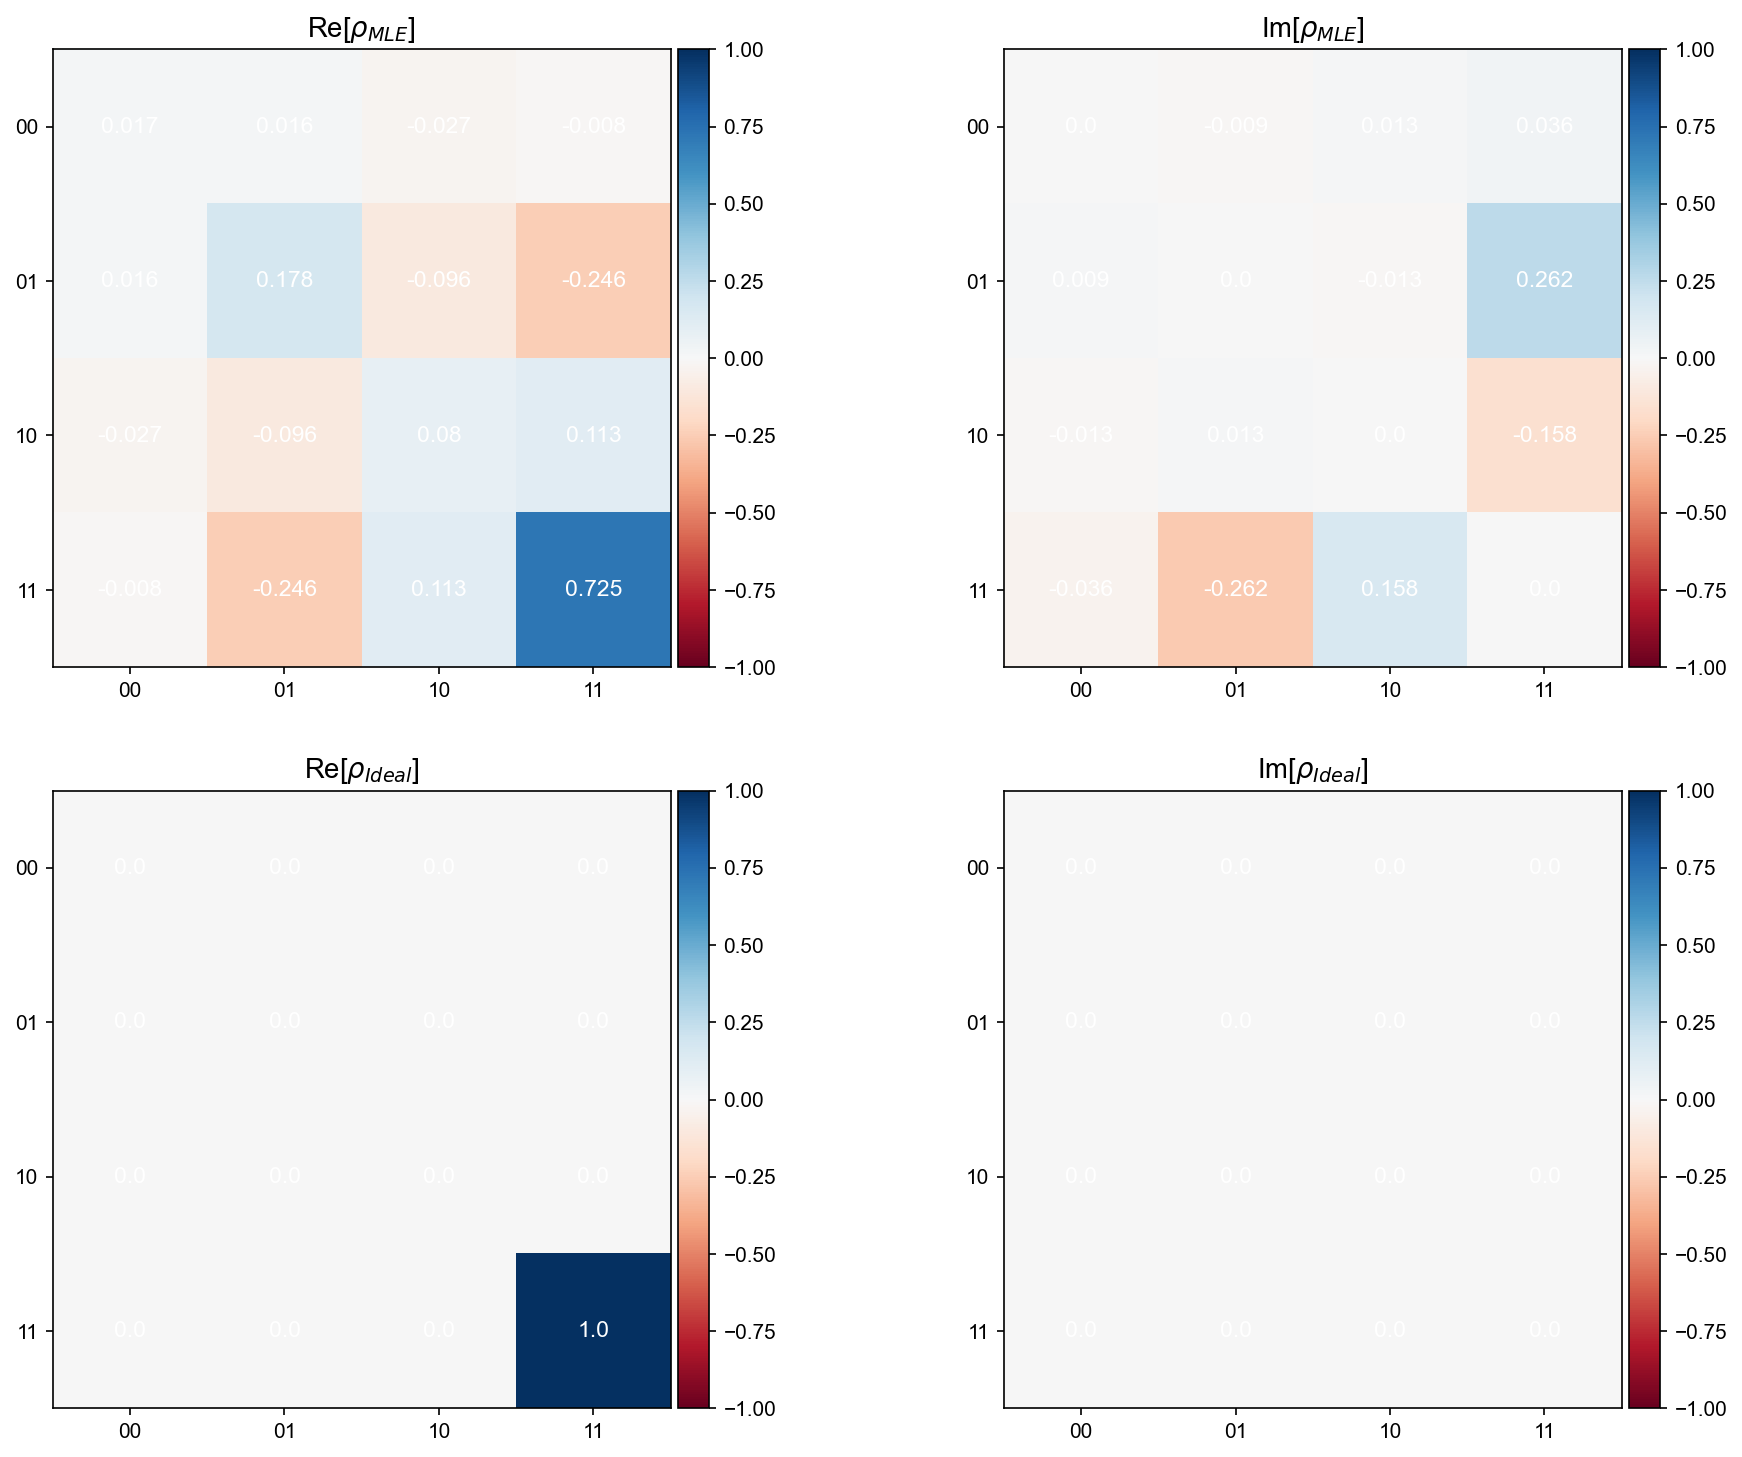

In [70]:
show_plot_rho_2d(rho_MLE_base, rho_id)

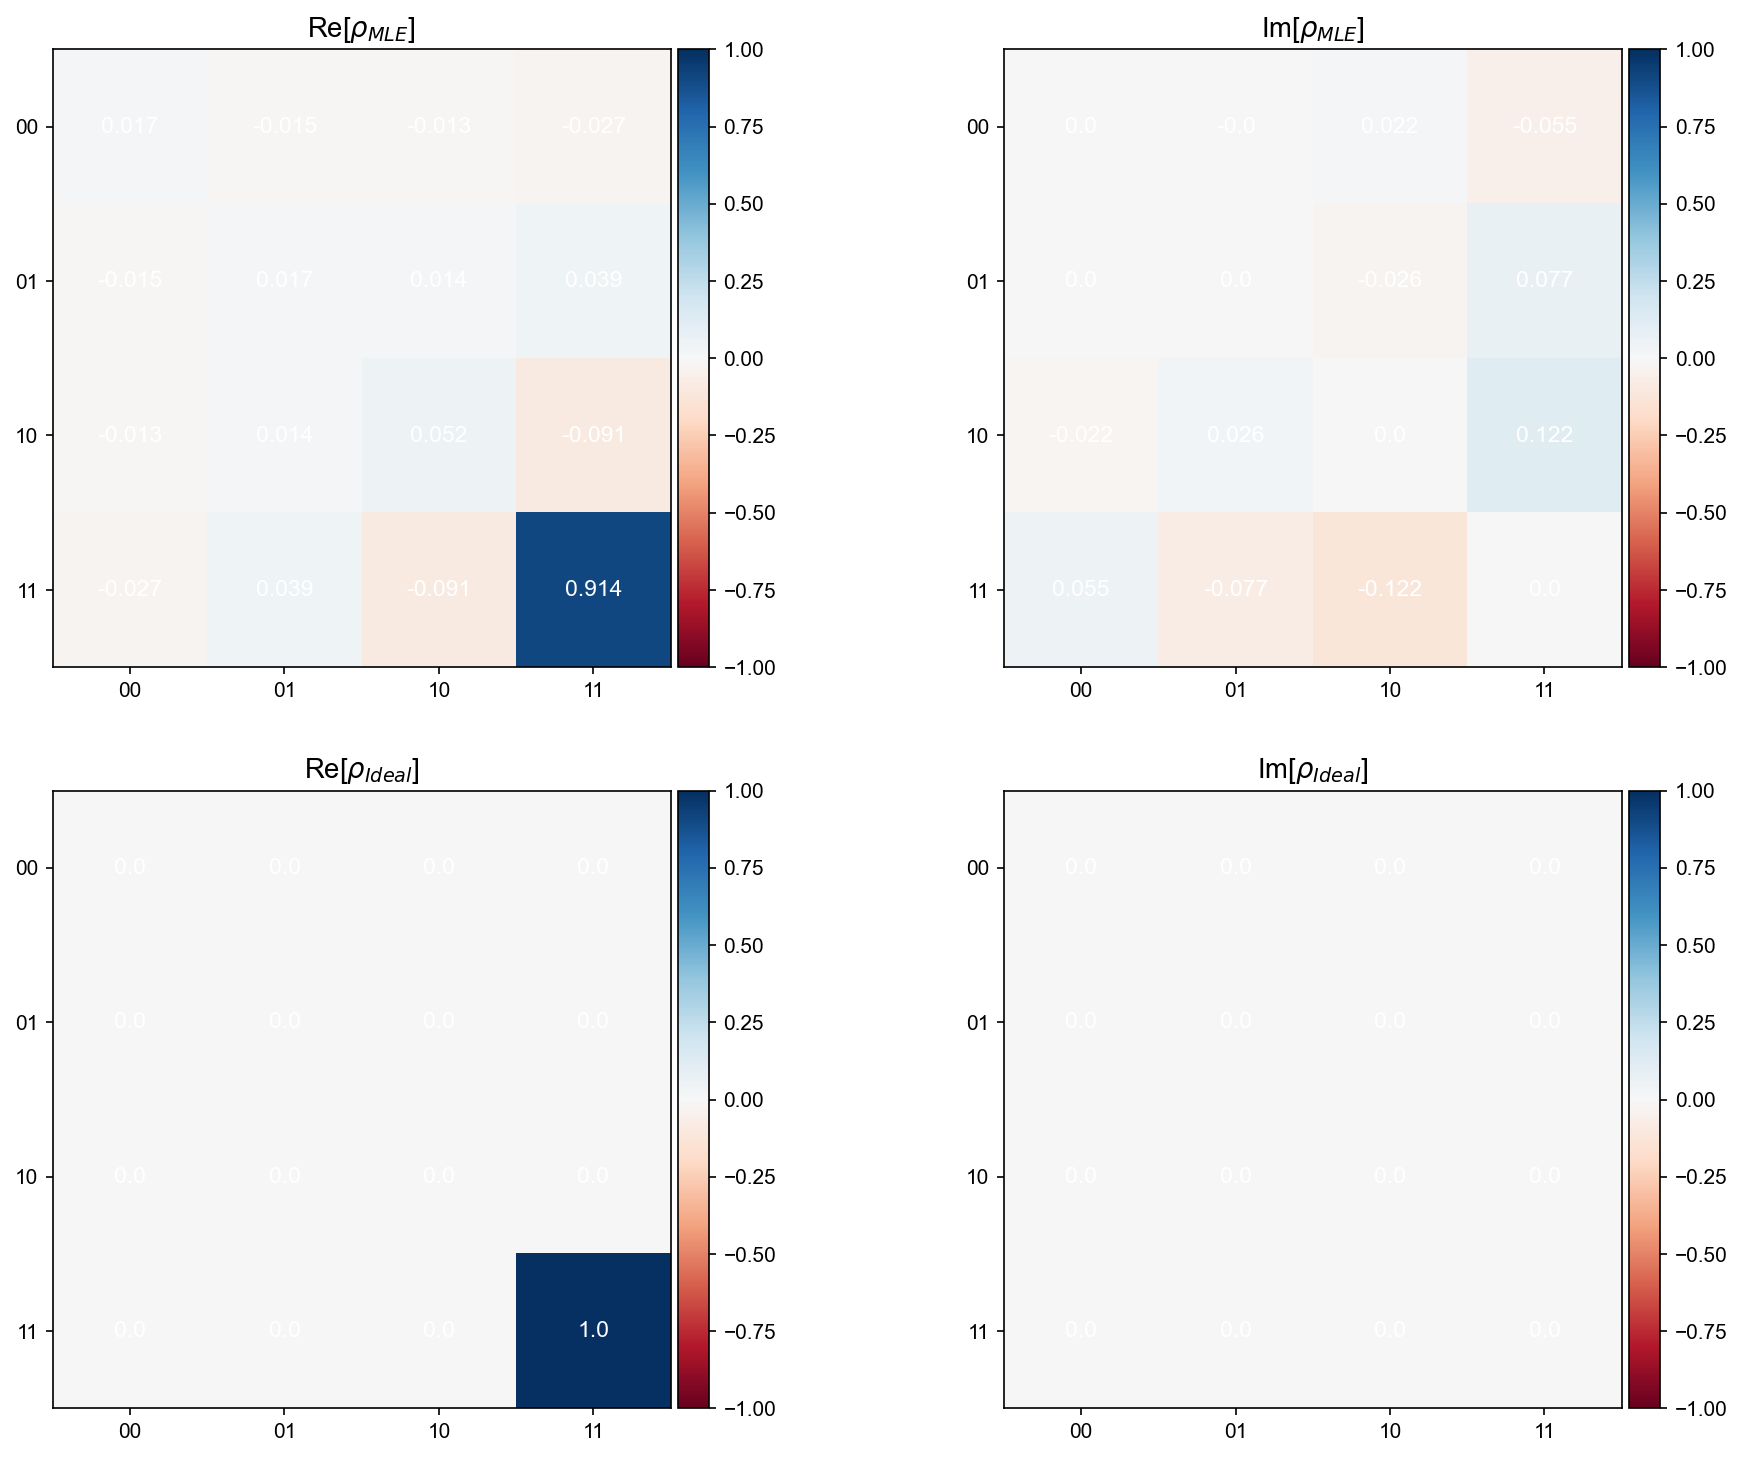

In [71]:
show_plot_rho_2d(rho_MLE_ZZ, rho_id)

In [157]:
tomo.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_EgGf_state_tomo_01.h5
